<a href="https://colab.research.google.com/github/pop756/Pasqal_chanllenge/blob/main/Mockup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [657]:
#!pip install pulser

In [658]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import MockDevice as DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

In [674]:
import numpy as np
import pandas as pd
import networkx as nx
diagonal = -20

def generate_distance_weighted_Q_matrix_with_soft_constraint(size=7, diagonal=-10, max_edges=4, penalty_term=5.0, hamming_weight=3, seed=42):
    """
    각 노드가 최대 max_edges 개의 엣지를 가지면서, 거리가 멀어질수록 가중치가 작아지는 Q 행렬을 생성.
    또한, 특정 개수만 선택되도록 하는 soft constraint를 추가.

    :param size: 생성할 행렬의 크기 (size x size)
    :param diagonal: 대각 원소 값
    :param max_edges: 각 노드가 가질 수 있는 최대 엣지 개수
    :param penalty_term: Hamming weight 제약을 위한 패널티 값
    :param hamming_weight: 선택해야 하는 노드 개수
    :param seed: 랜덤 시드 값 (재현 가능성 유지)
    :return: 거리 기반 가중치를 가지는 Q 행렬 (numpy array), 그래프, 노드 좌표
    """
    np.random.seed(seed)

    # 노드의 랜덤한 2D 좌표 생성
    coordinates = np.random.rand(size, 2) * 10  # 10x10 범위 내에서 랜덤 좌표

    # 노드 간 거리 계산
    distances = pdist(coordinates)  # 1D 배열 형태의 거리 정보
    distance_matrix = squareform(distances)  # 2D 대칭 행렬로 변환

    # 가중치는 거리의 역수의 제곱으로 설정 (거리가 멀어질수록 값이 작아짐)
    weights = 1 / (distance_matrix + np.eye(size))**2  # 자기 자신과의 거리는 제외
    print( weights)
    # 그래프를 생성하여 각 노드의 연결을 제한
    G = nx.Graph()
    for i in range(size):
        G.add_node(i, pos=coordinates[i])  # 노드 좌표 저장

    # 가장 가까운 max_edges 개의 노드만 연결
    edges = []
    for i in range(size):
        closest_nodes = np.argsort(distance_matrix[i])  # 거리 기준으로 정렬
        connected = 0

        for j in closest_nodes:
            if i == j or connected >= max_edges or G.degree[j] >= max_edges:
                continue

            if (i, j) not in edges and (j, i) not in edges and weights[i, j] > 0:  # 0이 아닌 경우만 추가
                edges.append((i, j))
                G.add_edge(i, j, weight=weights[i, j])  # 가중치 추가
                connected += 1

    # Q 행렬 초기화
    Q = np.zeros((size, size))

    # 그래프의 엣지를 기반으로 Q 행렬 채우기
    for i, j in edges:
        Q[i, j] = weights[i, j] * 50
        Q[j, i] = weights[j, i] * 50  # 대칭성 유지

    # 대각 성분 설정
    np.fill_diagonal(Q, diagonal)

    # Soft Constraint 추가 (Hamming weight 제약)
    for i in range(size):
        Q[i, i] += penalty_term * (1 - 2 * hamming_weight)  # Hamming weight 페널티 적용
        for j in range(i + 1, size):
            Q[i, j] +=  penalty_term
            Q[j, i] +=  penalty_term  # 대칭성 유지

    return Q/10, G, coordinates


# 12x12 Q 행렬 생성 (Soft Constraint 포함)
Q, _, _ = generate_distance_weighted_Q_matrix_with_soft_constraint(
    size=6, diagonal=-10, penalty_term=290.0, hamming_weight=2
)
Q



[[1.         0.03972723 0.01472036 0.0932041  0.09073489 0.07958422]
 [0.03972723 1.         0.0189502  0.0190215  0.34363389 0.01552961]
 [0.01472036 0.0189502  1.         0.01945718 0.01988463 0.01468859]
 [0.0932041  0.0190215  0.01945718 1.         0.03126174 0.82190436]
 [0.09073489 0.34363389 0.01988463 0.03126174 1.         0.02465639]
 [0.07958422 0.01552961 0.01468859 0.82190436 0.02465639 1.        ]]


array([[-88.        ,  29.19863613,  29.        ,  29.46602048,
         29.45367444,  29.39792109],
       [ 29.19863613, -88.        ,  29.094751  ,  29.09510751,
         30.71816947,  29.07764807],
       [ 29.        ,  29.094751  , -88.        ,  29.09728588,
         29.09942315,  29.07344295],
       [ 29.46602048,  29.09510751,  29.09728588, -88.        ,
         29.15630869,  33.10952182],
       [ 29.45367444,  30.71816947,  29.09942315,  29.15630869,
        -88.        ,  29.        ],
       [ 29.39792109,  29.07764807,  29.07344295,  33.10952182,
         29.        , -88.        ]])

In [675]:

def evaluate_mapping(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    Q_copy = np.array(Q)
    np.fill_diagonal(Q_copy, 0)
    print(np.linalg.norm(new_Q - Q_copy))
    return np.linalg.norm(new_Q - Q_copy)

In [676]:
def evaluate_mapping_Q(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    Q_copy = np.array(Q)
    np.fill_diagonal(new_Q, Q[0][0])

    return new_Q

In [677]:
costs = []
np.random.seed(25)
# 초기 좌표를 정N각형의 형태로 배치
angles = np.linspace(0, 2 * np.pi, Q.shape[0], endpoint=False)
initial_positions = np.column_stack(( np.cos(angles),  np.sin(angles)))*5
initial_positions = np.reshape(initial_positions,-1)
res = minimize(
    evaluate_mapping,
    initial_positions,
    args=(Q,),
    method="COBYLA",
    tol=1e-6,
    options={"maxiter": 500, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))
Q_cord = evaluate_mapping_Q(coords, Q)

1103.8484657628978
953.5866566441669
1066.196012971034
937.1858367706737
833.4403704539052
826.2365437688627
829.6216079349949
1119.5230708961565
877.5996689823469
1917.0556823055983
1573.544701489115
807.1470278939695
1577.0273120430152
637.4612278026457
482.96319522821074
468.4872165439835
479.19095580835244
482.9896693947812
361.8378730118388
223.68581366338154
189.01962155391158
229.1874158333466
211.54011510509918
195.12655433947023
172.06293245662152
187.53629862978613
301.5610501820795
184.4130832266308
204.01564671271788
164.0425615179552
143.25993365118202
129.7207858239314
137.4601104779702
139.1724158603693
130.76094774809636
134.03904329105004
148.40917445288304
132.77903979337208
127.65907444159559
129.71644929736522
126.28173911770209
124.90660500643855
124.09022137507108
129.12390565545562
124.83500562263606
122.20216991637169
122.7268076000542
126.54245044295791
123.61011411630123
124.35147647977307
123.11617419726628
124.77142863691104
120.1878234687738
120.80631037627

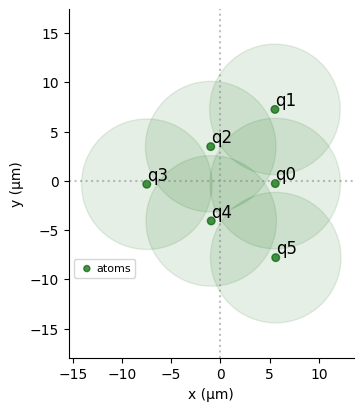

In [678]:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

In [679]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q @ z
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:6])

[('000011', -118.0), ('101000', -118.0), ('001001', -117.85311410767761), ('010001', -117.84470385325423), ('011000', -117.81049800595463), ('010100', -117.8097849771617)]


In [680]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q_cord @ z
    costs.append(cost)
zipped_cord = zip(bitstrings, costs)
sort_zipped_cord = sorted(zipped_cord, key=lambda x: x[1])
print(sort_zipped_cord[:6])

[('010101', -261.2114215458539), ('011101', -228.3155544972061), ('010111', -228.2797354556023), ('110101', -227.50861765250454), ('010011', -201.65875488659287), ('001101', -201.54590517007983)]


In [681]:
# We choose a median value between the min and the max
Omega = np.median(Q[Q > 0].flatten())
delta_0 = Q[0][0]  # just has to be negative
delta_f = -Q[0][0]  # just has to be positive
T = 4000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

In [682]:
from pulser import Pulse, Sequence
from pulser.waveforms import RampWaveform

def apply_detuning_to_global_pulse(global_pulse, detuning_list, qubits):
    """
    기존 global pulser를 받아서 각 큐비트에 개별 detuning을 적용하는 함수.

    :param global_pulse: 기존 global하게 적용되는 Pulser Pulse 객체
    :param detuning_list: 각 큐비트에 적용할 detuning 값 리스트
    :param qubits: 큐비트 리스트 (sequence에서 사용할 register)
    :return: 새로운 Pulser Sequence 객체
    """
    # 새로운 시퀀스 생성
    seq = Sequence(register=qubits)

    # 원래 global pulse의 duration 가져오기
    duration = global_pulse.duration

    for i, detuning in enumerate(detuning_list):
        # 새로운 detuning 값을 적용한 waveform 생성 (RampWaveform 활용)
        detuning_waveform = RampWaveform(duration, global_pulse.detuning.amplitude, detuning)

        # 새로운 Pulse 생성 (Rabi frequency와 phase는 기존과 동일, detuning만 변경)
        new_pulse = Pulse(
            amplitude=global_pulse.amplitude,
            detuning=detuning_waveform,
            phase=global_pulse.phase,
            duration=duration
        )

        # 특정 큐비트에 적용
        seq.add(new_pulse, qubits[i])

    return seq


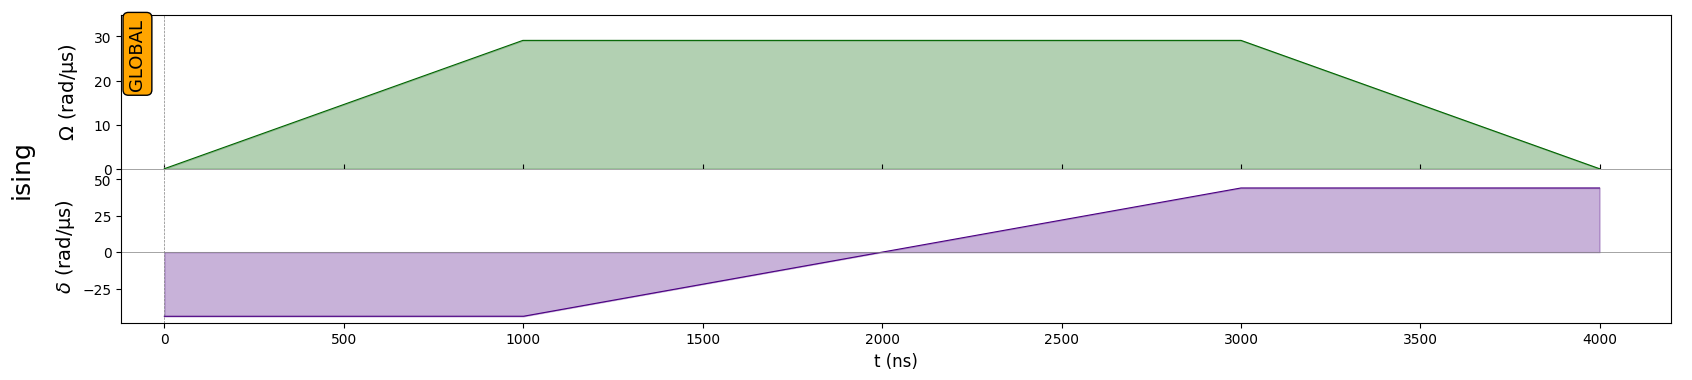

' seq_2 = Sequence(reg, DigitalAnalogDevice)\nseq_2.declare_channel("ising", "rydberg_global")\nseq_2.add(adiabatic_pulse_2, "ising") '

In [683]:
import pulser
adiabatic_pulse_list = [Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [Q[i][i]/2, 0, -Q[i][i]/2]),
    0,
) for i in range(len(Q))]

adiabatic_pulse_2 = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0/2, 0, delta_f/2]),
    0,
)


seq_1 = Sequence(reg, DigitalAnalogDevice)
#seq_1.declare_channel("ising", "rydberg_global")


for i in range(len(adiabatic_pulse_list)):

  seq_1.declare_channel(f"ch{i}", "rydberg_local")
  seq_1.target(f"q{i}", f"ch{i}")
  seq_1.add(adiabatic_pulse_list[i], f"ch{i}")




rise = pulser.Pulse.ConstantDetuning(
    pulser.RampWaveform(T/4, 0.0, Omega), delta_0/2, 0.0
)
sweep = pulser.Pulse.ConstantAmplitude(
    Omega, pulser.RampWaveform(T*2/4, delta_0/2, delta_f/2), 0.0
)
fall = pulser.Pulse.ConstantDetuning(
    pulser.RampWaveform(T/4 , Omega, 0.0), delta_f/2, 0.0
)

seq_2 = Sequence(reg, DigitalAnalogDevice)
seq_2.declare_channel("ising", "rydberg_global")
seq_2.add(rise, "ising")
seq_2.add(sweep, "ising")
seq_2.add(fall, "ising")
seq_2.draw(mode="input")


''' seq_2 = Sequence(reg, DigitalAnalogDevice)
seq_2.declare_channel("ising", "rydberg_global")
seq_2.add(adiabatic_pulse_2, "ising") '''


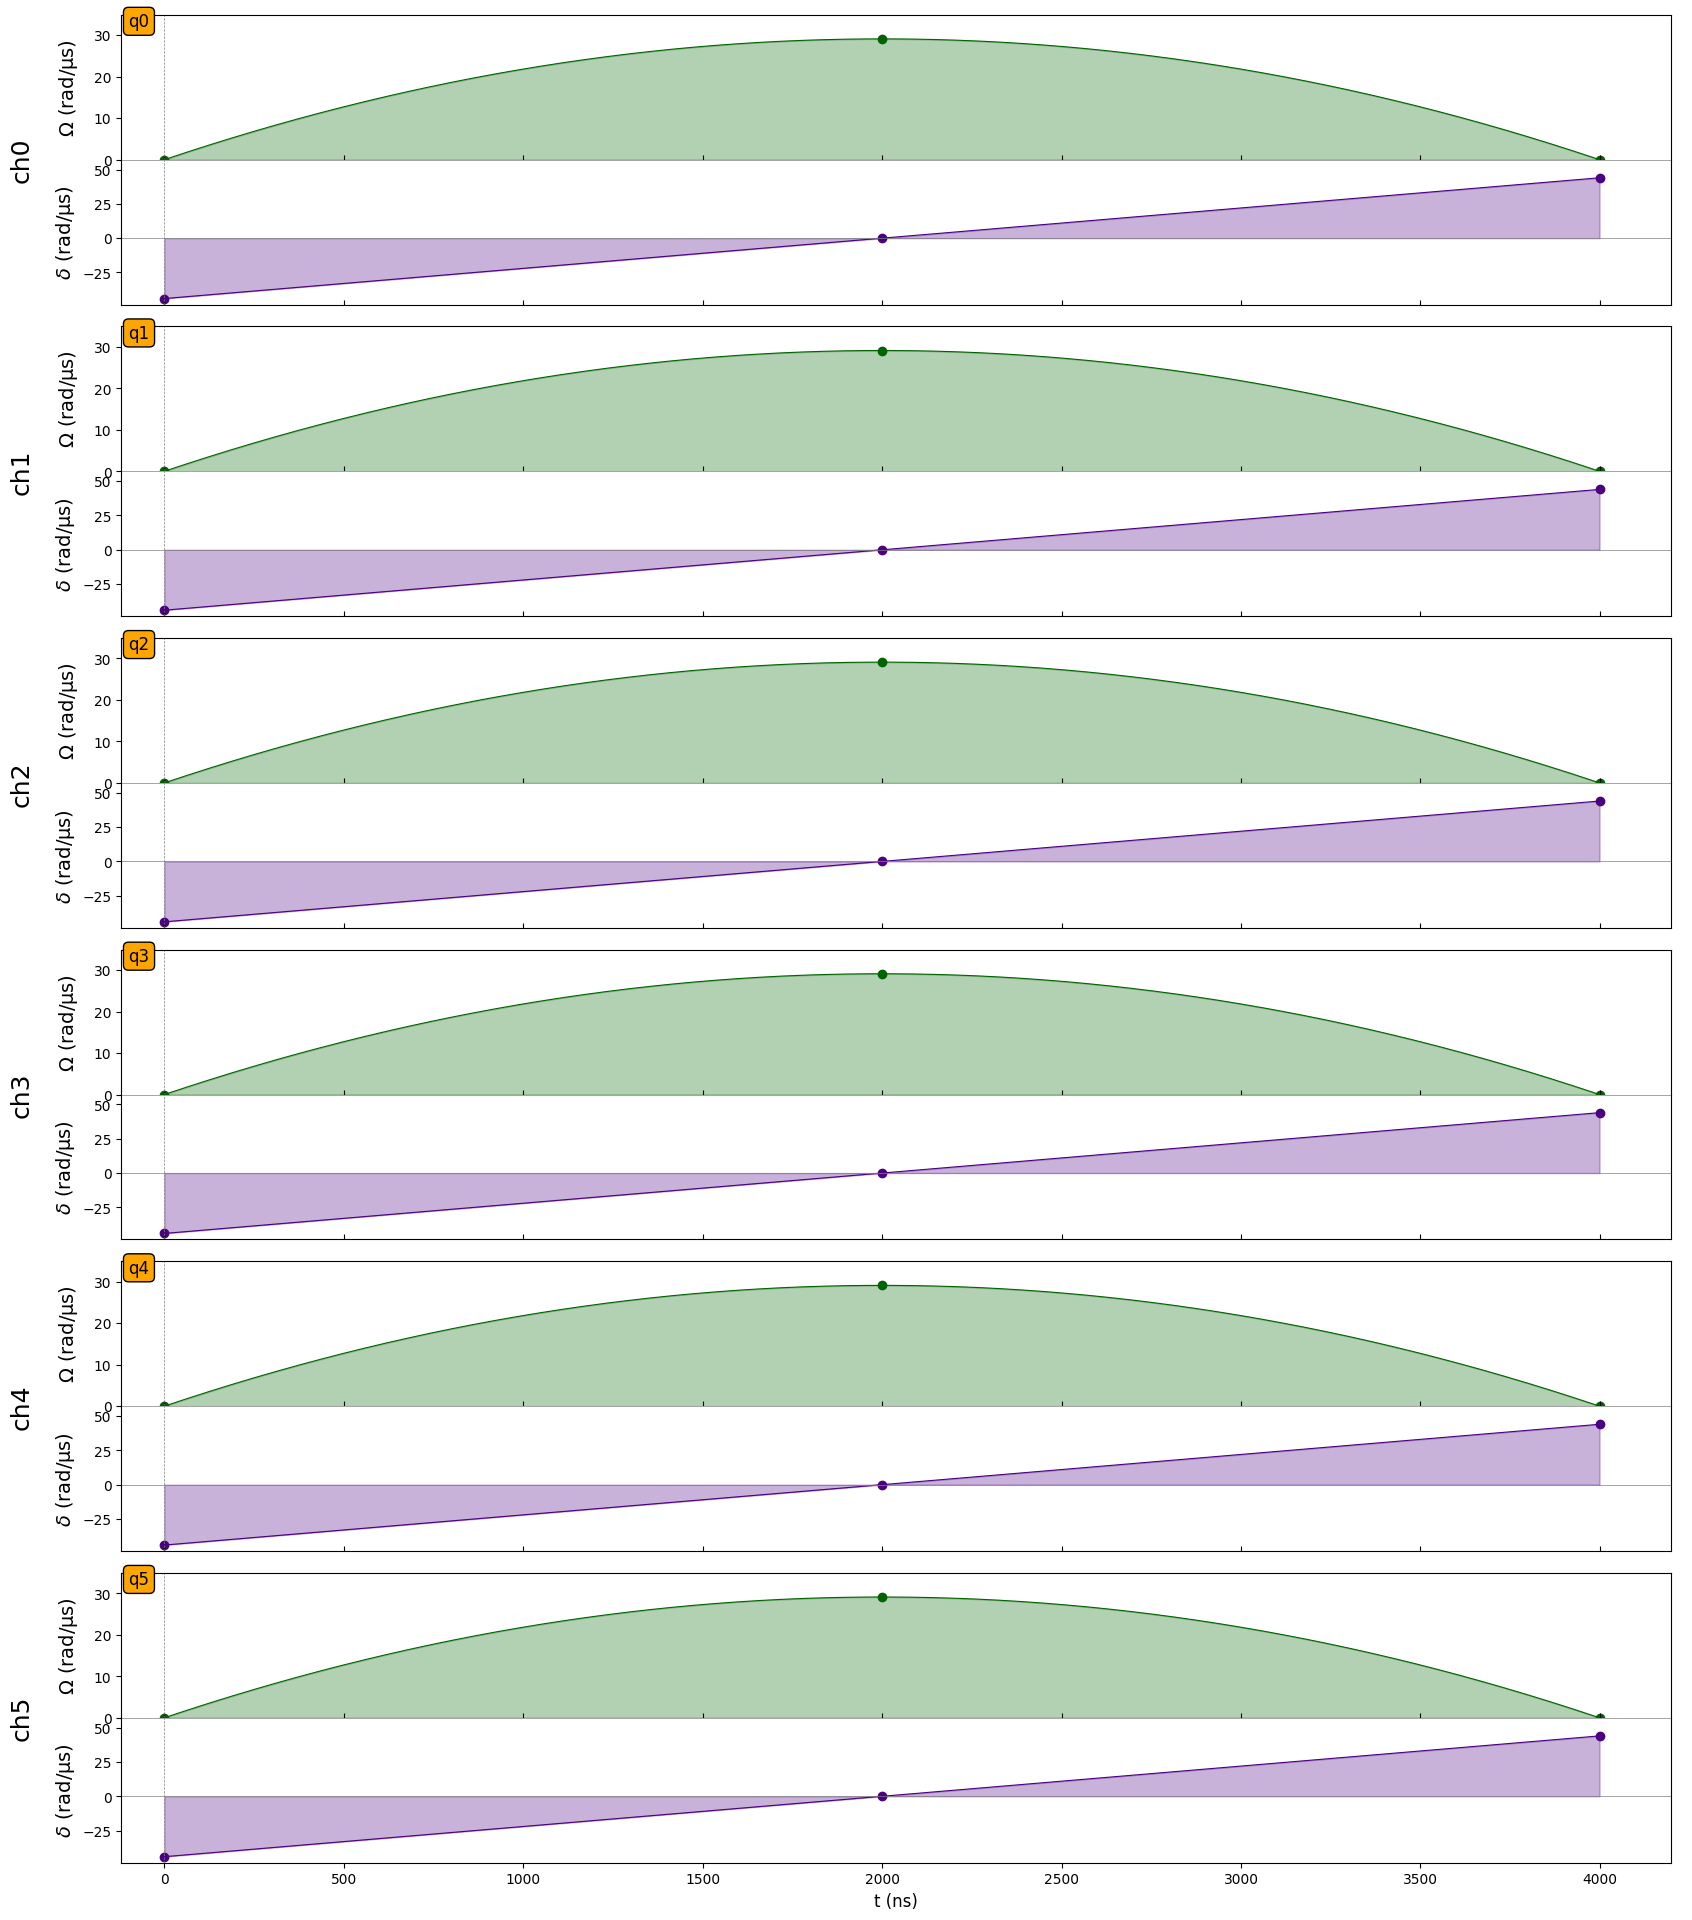

In [684]:
seq_1.draw()

In [685]:
simul_1 = QutipEmulator.from_sequence(seq_1)
results_1 = simul_1.run()
final_1 = results_1.get_final_state()
count_dict_1 = results_1.sample_final_state()

In [686]:

simul_2 = QutipEmulator.from_sequence(seq_2)
results_2 = simul_2.run()
final_2 = results_2.get_final_state()
count_dict_2 = results_2.sample_final_state()

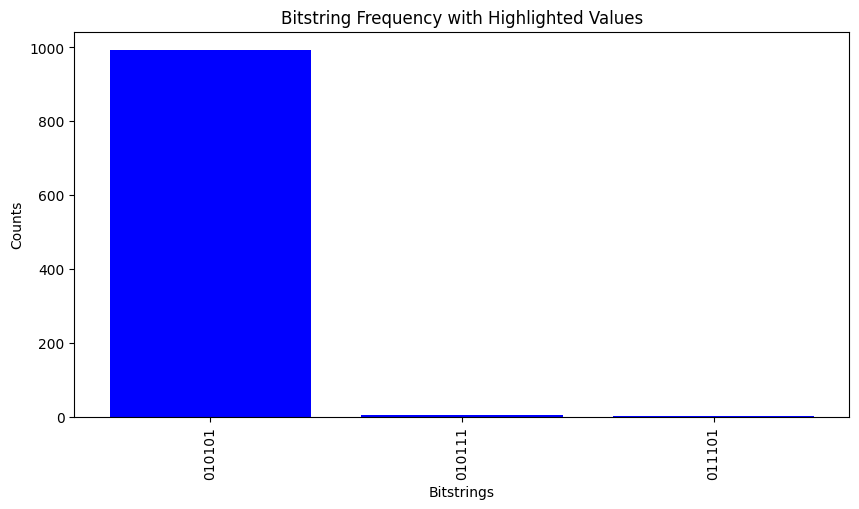

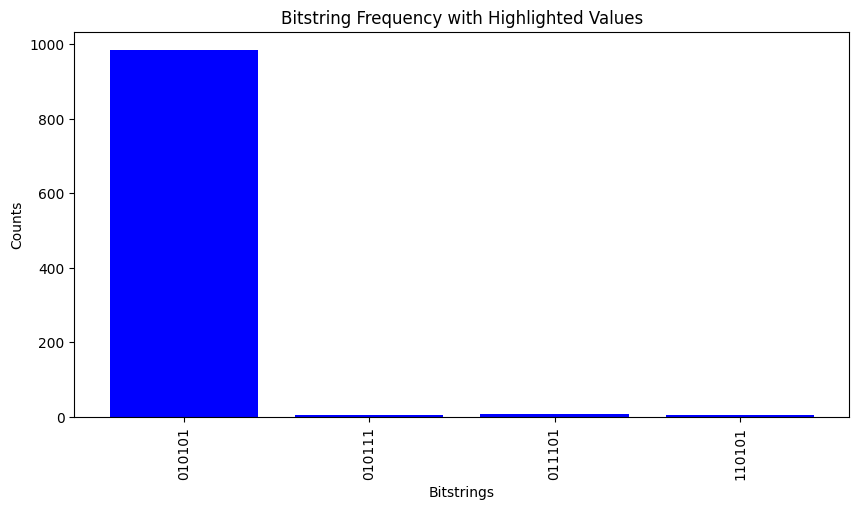

In [687]:
import matplotlib.pyplot as plt
from collections import Counter
def plot_bitstring_counts(input_data, bitstring_counts):
    """
    입력된 bitstring 목록을 기반으로 주어진 bitstring_counts에서 해당 bitstring을
    빨간색 막대로 강조하고, 나머지는 파란색으로 표시하는 그래프를 생성합니다.

    :param input_data: List of tuples (bitstring, value)
    :param bitstring_counts: Dictionary (bitstring -> count)
    """
    import matplotlib.pyplot as plt

    # 빨간색으로 강조할 bitstring 목록 추출
    highlighted_strings = {bitstring for bitstring, _ in input_data}

    # 데이터 준비
    bitstrings = list(bitstring_counts.keys())
    counts = list(bitstring_counts.values())
    colors = ['red' if bitstring in highlighted_strings else 'blue' for bitstring in bitstrings]

    # 막대 그래프 그리기
    plt.figure(figsize=(10, 5))
    plt.bar(bitstrings, counts, color=colors)
    plt.xlabel("Bitstrings")
    plt.ylabel("Counts")
    plt.title("Bitstring Frequency with Highlighted Values")
    plt.xticks(rotation=90)
    plt.show()



plot_bitstring_counts(sort_zipped[:2], count_dict_1)
plot_bitstring_counts(sort_zipped[:2], count_dict_2)

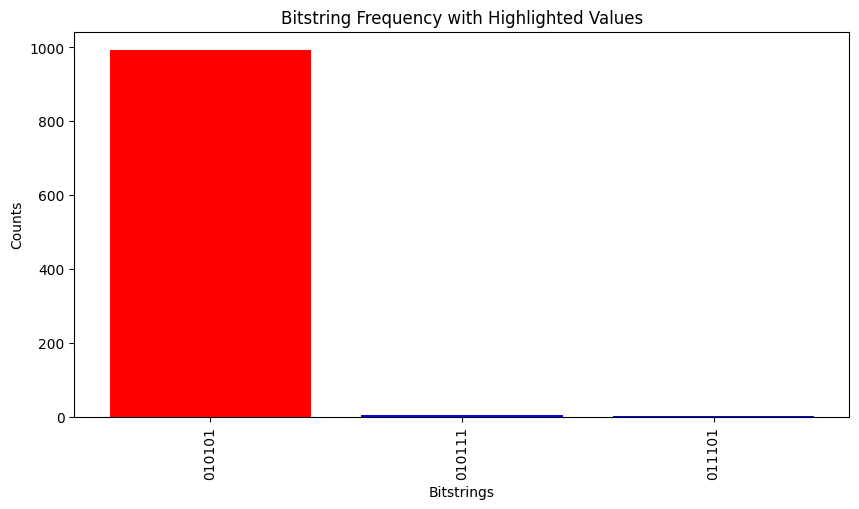

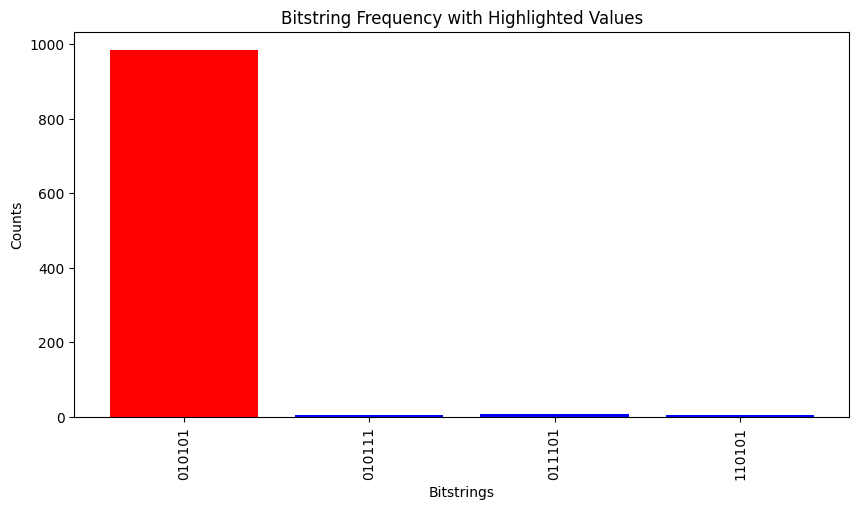

In [689]:

import matplotlib.pyplot as plt
from collections import Counter
def plot_bitstring_counts(input_data, bitstring_counts):
    """
    입력된 bitstring 목록을 기반으로 주어진 bitstring_counts에서 해당 bitstring을
    빨간색 막대로 강조하고, 나머지는 파란색으로 표시하는 그래프를 생성합니다.

    :param input_data: List of tuples (bitstring, value)
    :param bitstring_counts: Dictionary (bitstring -> count)
    """
    import matplotlib.pyplot as plt

    # 빨간색으로 강조할 bitstring 목록 추출
    highlighted_strings = {bitstring for bitstring, _ in input_data}

    # 데이터 준비
    bitstrings = list(bitstring_counts.keys())
    counts = list(bitstring_counts.values())
    colors = ['red' if bitstring in highlighted_strings else 'blue' for bitstring in bitstrings]

    # 막대 그래프 그리기
    plt.figure(figsize=(10, 5))
    plt.bar(bitstrings, counts, color=colors)
    plt.xlabel("Bitstrings")
    plt.ylabel("Counts")
    plt.title("Bitstring Frequency with Highlighted Values")
    plt.xticks(rotation=90)
    plt.show()



plot_bitstring_counts(sort_zipped_cord[:1], count_dict_1)
plot_bitstring_counts(sort_zipped_cord[:1], count_dict_2)